# Consolidated Backtesting Notebook
 In this notebook we run and compare three trading strategies:
 1. Moving Average Crossover Strategy
 2. 500-Days Halving Strategy
 3. DQN Agent Strategy


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf

## 1. Moving Average Strategy Backtest
This function implements the moving average crossover strategy. It returns the full DataFrame (with backtest results)
and a dictionary of metrics including final portfolio value, profit, annualized return, Sharpe ratio, maximum drawdown,
win rate, and loss rate.

In [2]:
def moving_average_backtest(data, short_window=24, long_window=96, initial_capital=10000):
    df = data.copy()
    # Calculate moving averages
    df['short_ma'] = df['close'].rolling(window=short_window).mean()
    df['long_ma'] = df['close'].rolling(window=long_window).mean()
    
    # Generate signals: 1 for long when short_ma > long_ma, -1 for short otherwise.
    df['signal'] = 0
    df.loc[df.index[long_window:], 'signal'] = np.where(
        df['short_ma'].loc[df.index[long_window:]] > df['long_ma'].loc[df.index[long_window:]], 1, -1
    )
    
    # Identify position changes (trading events)
    df['position_change'] = df['signal'].diff()
    
    # Compute returns and strategy returns
    df['returns'] = df['close'].pct_change()
    df['strategy_returns'] = df['returns'] * df['signal'].shift(1)
    df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()
    df['portfolio_value'] = initial_capital * df['cumulative_returns']
    
    final_portfolio_value = df['portfolio_value'].iloc[-1]
    profit = final_portfolio_value - initial_capital

    # Annualized Return
    time_period = (df.index[-1] - df.index[0]).total_seconds() / (365.25 * 24 * 3600)
    annualized_return = (final_portfolio_value / initial_capital) ** (1 / time_period) - 1

    # Sharpe Ratio (risk-free rate assumed 0, hourly annualization)
    mean_ret = df['strategy_returns'].mean()
    std_ret = df['strategy_returns'].std()
    annual_factor = 365.25 * 24
    sharpe_ratio = (mean_ret / std_ret) * np.sqrt(annual_factor) if std_ret != 0 else np.nan

    # Maximum Drawdown
    df['running_max'] = df['portfolio_value'].cummax()
    df['drawdown'] = df['portfolio_value'] / df['running_max'] - 1
    max_drawdown = df['drawdown'].min()

    # Win Rate & Loss Rate via trade-by-trade returns
    trade_signals = df[df['position_change'] != 0][['close', 'signal']].sort_index()
    trades = []
    for i in range(len(trade_signals) - 1):
        entry = trade_signals.iloc[i]
        exit = trade_signals.iloc[i+1]
        if entry['signal'] == 1:
            trade_return = exit['close'] / entry['close'] - 1
        elif entry['signal'] == -1:
            trade_return = entry['close'] / exit['close'] - 1
        else:
            continue
        trades.append(trade_return)
    trades = np.array(trades)
    win_rate = np.sum(trades > 0) / len(trades) if len(trades) > 0 else np.nan
    loss_rate = np.sum(trades < 0) / len(trades) if len(trades) > 0 else np.nan

    metrics = {
        "final_portfolio_value": final_portfolio_value,
        "profit": profit,
        "annualized_return": annualized_return,
        "sharpe_ratio": sharpe_ratio,
        "max_drawdown": max_drawdown,
        "win_rate": win_rate,
        "loss_rate": loss_rate
    }
    
    return df, metrics

Load raw Bitcoin price data for moving average strategy

In [4]:
ma_data = pd.read_csv("../Transform_data/raw_data/2023-2018_BTC-USD_Data_1h.csv")
ma_data['date'] = pd.to_datetime(ma_data['date'], format='%d.%m.%Y %H:%M')
ma_data.sort_values('date', inplace=True)
ma_data.set_index('date', inplace=True)

df_ma, metrics_ma = moving_average_backtest(ma_data)
print("Moving Average Strategy Metrics:")
for k, v in metrics_ma.items():
    print(f"{k}: {v}")

Moving Average Strategy Metrics:
final_portfolio_value: 14968.966474319996
profit: 4968.9664743199955
annualized_return: 0.074267021257717
sharpe_ratio: 0.4514172620377163
max_drawdown: -0.6698768770151349
win_rate: 0.3
loss_rate: 0.7


(Optional) Plot the portfolio value evolution for Moving Average strategy

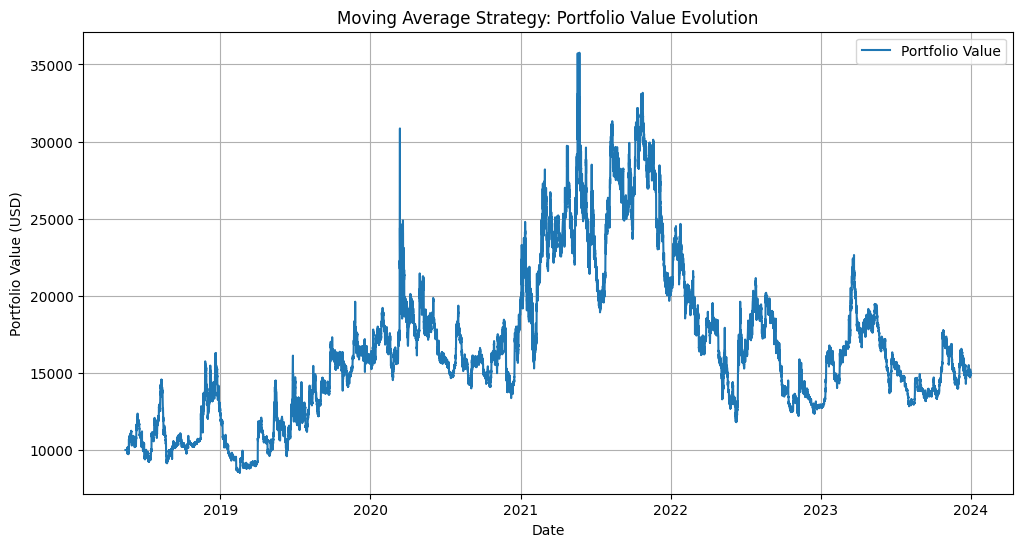

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df_ma.index, df_ma['portfolio_value'], label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.title('Moving Average Strategy: Portfolio Value Evolution')
plt.legend()
plt.grid(True)
plt.show()

## 2. 500-Days Halving Strategy Backtest

This section replicates the halving strategy notebook.
It downloads BTC data via yfinance and computes cumulative growth based on 500-day cycles around halving events.


In [6]:
def halving_strategy_backtest():
    # Define halving dates (include future prediction if desired)
    halving_dates = [
        datetime(2016, 7, 9),
        datetime(2020, 5, 11),
        datetime(2024, 4, 21)  # Predicted future date
    ]
    start_date = datetime(2010, 1, 1)
    end_date = datetime.now() - timedelta(days=3)
    
    # Download BTC data from yfinance
    btc_data = yf.download("BTC-USD", start=start_date, end=end_date)
    btc_data.index = pd.to_datetime(btc_data.index)
    
    final_results = pd.Series(dtype=float)
    current_multiplier = 1  # Start multiplier
    # Use first 500-day period based on first halving date
    first_1000_start = max(start_date, halving_dates[0] - timedelta(days=500))
    buy_and_hold_data = btc_data[btc_data.index >= first_1000_start]
    buy_and_hold_start_price = buy_and_hold_data.iloc[0]['Close']
    buy_and_hold_growth = buy_and_hold_data['Close'] / buy_and_hold_start_price
    
    for halving_date in halving_dates:
        date_before = max(start_date, halving_date - timedelta(days=500))
        date_after = halving_date + timedelta(days=500)
        data_in_range = btc_data[(btc_data.index >= date_before) & (btc_data.index <= date_after)]
        if data_in_range.empty:
            continue
        price_before = data_in_range.iloc[0]['Close']
        daily_changes = (data_in_range['Close'] / price_before) * current_multiplier
        if not daily_changes.empty and not final_results.empty:
            final_results = pd.concat([final_results, daily_changes])
        elif not daily_changes.empty:
            final_results = daily_changes
        current_multiplier = daily_changes.iloc[-1]
    
    # Final multiplication factor from the halving strategy
    # At the end of halving_strategy_backtest():
    final_growth = float(final_results.iloc[-1]) if not final_results.empty else np.nan
    buy_and_hold_final = float(buy_and_hold_growth.iloc[-1]) if not buy_and_hold_growth.empty else np.nan

    metrics = {
        "final_growth": final_growth,
        "buy_and_hold_final": buy_and_hold_final
    }

    return btc_data, final_results, buy_and_hold_growth, metrics


In [10]:
btc_data, final_results, buy_and_hold_growth, metrics_halving = halving_strategy_backtest()
print("\nHalving Strategy Metrics:")
for k, v in metrics_halving.items():
    print(f"{k}: {v}")

[*********************100%***********************]  1 of 1 completed


Halving Strategy Metrics:
final_growth: 1894.777190546647
buy_and_hold_final: 353.5987751331152



C:\Users\ntekaatl\AppData\Local\Temp\ipykernel_29348\2366223398.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_growth = float(final_results.iloc[-1]) if not final_results.empty else np.nan
C:\Users\ntekaatl\AppData\Local\Temp\ipykernel_29348\2366223398.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  buy_and_hold_final = float(buy_and_hold_growth.iloc[-1]) if not buy_and_hold_growth.empty else np.nan


(Optional) Plot the cumulative growth from halving strategy vs. buy-and-hold

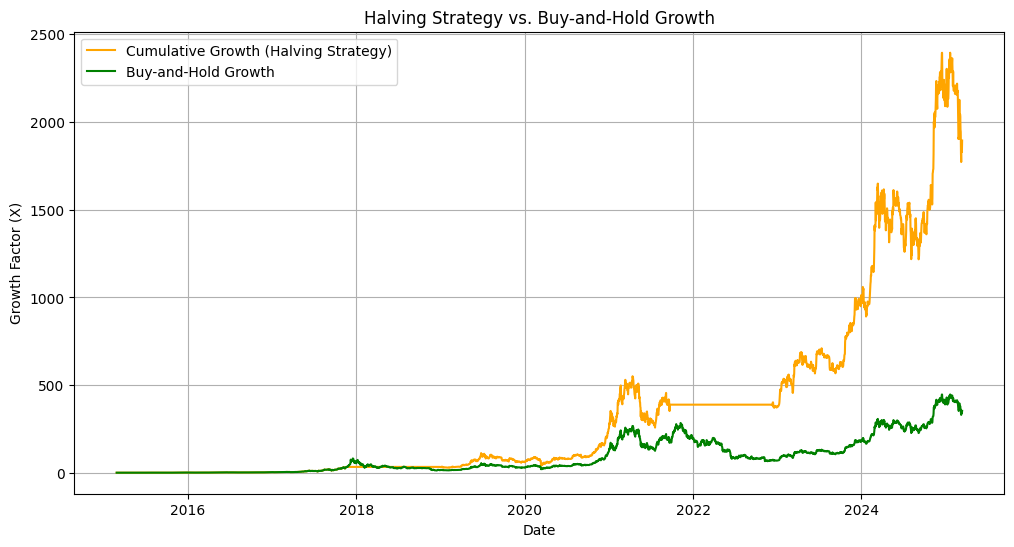

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(final_results.index, final_results, color='orange', label='Cumulative Growth (Halving Strategy)')
plt.plot(buy_and_hold_growth.index, buy_and_hold_growth, color='green', label='Buy-and-Hold Growth')
plt.xlabel("Date")
plt.ylabel("Growth Factor (X)")
plt.title("Halving Strategy vs. Buy-and-Hold Growth")
plt.legend()
plt.grid(True)
plt.show()

## 3. DQN Agent Strategy Backtest

This section uses a trained DQN agent and your custom TradingEnv to run a test episode.
(Ensure that the TradingEnv class, scaler, and model file are available in the specified paths.)


In [16]:
%run ../Environment/environment.ipynb

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'environment.ipynb' matched no files


In [23]:
def dqn_agent_backtest():
    from stable_baselines3 import DQN
    from stable_baselines3.common.vec_env import DummyVecEnv
    # Import your TradingEnv. Make sure that environment.ipynb is exported as a module or convert its code into a .py file.
    # try:
    #     from Environment.environment import TradingEnv
    # except ImportError:
    #     raise ImportError("Could not import TradingEnv. Check your environment file and paths.")
    
    # Load test data (for the DQN strategy, you may have a standardized dataset)
    test_data = pd.read_csv("../Transform_data/stand_data/2025-2024_stand_data.csv")
    test_data.drop('datetime', axis=1, inplace=True)
    
    env = TradingEnv(
        data=test_data,
        initial_cash=10000,
        window_size=336,
        scaler_path="../Transform_data/scaler.pkl",
        default_seed=42
    )
    
    # Load the pre-trained DQN model (make sure the file exists)
    try:
        model = DQN.load("../Agents/DQN/dqn_trading_model")
    except Exception as e:
        raise RuntimeError(f"Failed to load DQN model: {e}")
    
    obs, info = env.reset(seed=42)
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(int(action))
    final_portfolio_value = env.portfolio_value
    profit = final_portfolio_value - 10000
    
    metrics = {
        "final_portfolio_value": final_portfolio_value,
        "profit": profit
    }
    return env, metrics

In [24]:
try:
    env_dqn, metrics_dqn = dqn_agent_backtest()
    print("\nDQN Agent Strategy Metrics:")
    for k, v in metrics_dqn.items():
        print(f"{k}: {v}")
except Exception as e:
    print("\nDQN Agent backtest failed:", e)
    metrics_dqn = {}

Seed in the environment: 42


c:\Users\ntekaatl\OneDrive - Cisco\Documents\A Studientarbeit\Kaka\Studienarbeit\trading_env\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 30.92GB > 3.90GB
  warnings.warn(


Seed in the environment: 42

DQN Agent Strategy Metrics:
final_portfolio_value: 12079.768853361082
profit: 2079.7688533610817


## 4. Strategy Comparison
We now collect metrics from all three strategies into a DataFrame and plot a comparison.


In [25]:
comparison = pd.DataFrame({
    "Strategy": ["Moving Average", "Halving", "DQN Agent"],
    "Final Value / Growth": [
        metrics_ma.get("final_portfolio_value", np.nan),
        metrics_halving.get("final_growth", np.nan),
        metrics_dqn.get("final_portfolio_value", np.nan)
    ],
    "Profit / Return": [
        metrics_ma.get("profit", np.nan),
        np.nan,  # For the halving strategy we use a growth factor rather than direct profit
        metrics_dqn.get("profit", np.nan)
    ],
    "Annualized Return": [
        metrics_ma.get("annualized_return", np.nan),
        np.nan,
        np.nan
    ],
    "Sharpe Ratio": [
        metrics_ma.get("sharpe_ratio", np.nan),
        np.nan,
        np.nan
    ],
    "Max Drawdown": [
        metrics_ma.get("max_drawdown", np.nan),
        np.nan,
        np.nan
    ]
})

print("\nComparison of Strategies:")
print(comparison)


Comparison of Strategies:
         Strategy  Final Value / Growth  Profit / Return  Annualized Return  \
0  Moving Average          14968.966474      4968.966474           0.074267   
1         Halving           1894.777191              NaN                NaN   
2       DQN Agent          12079.768853      2079.768853                NaN   

   Sharpe Ratio  Max Drawdown  
0      0.451417     -0.669877  
1           NaN           NaN  
2           NaN           NaN  


# Plot comparison of Final Value / Growth

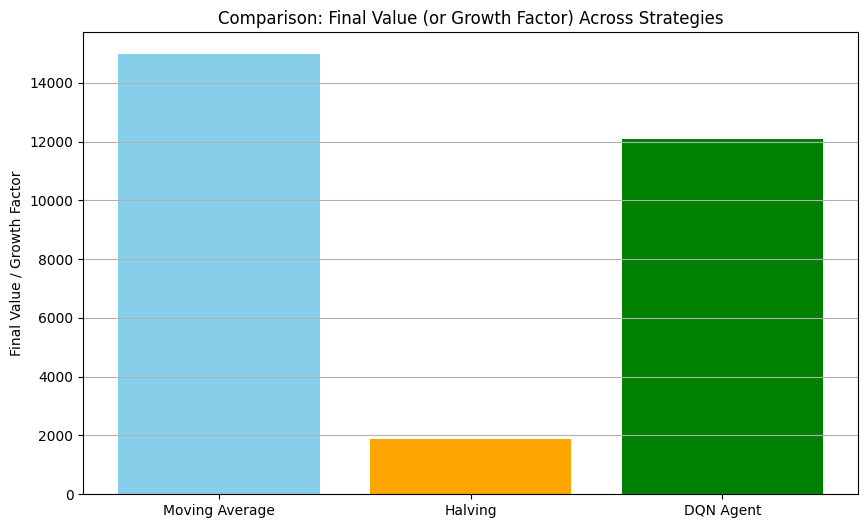

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(comparison["Strategy"], comparison["Final Value / Growth"], color=['skyblue', 'orange', 'green'])
plt.title("Comparison: Final Value (or Growth Factor) Across Strategies")
plt.ylabel("Final Value / Growth Factor")
plt.grid(axis='y')
plt.show()